In [421]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, color
import pandas as pd
from plotnine import *
import scipy.optimize as opt


In [287]:
low_score = 'low_score.mp4'
high_score = 'high_score.mp4'
def get_video_stats(filename):
    video=cv2.VideoCapture(filename)
    count=int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    reso = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    video.release()
    print(f'frames {count}, fps {fps}, resolution {reso}')
    

get_video_stats(low_score)
get_video_stats(high_score)

frames 5471, fps 30, resolution 1920
frames 10557, fps 60, resolution 1280


In [638]:
beans = np.zeros(width//pixel_w)
target_color = np.array([153, 118,  37])
target_color2 = np.array([209, 165, 55])
FALL_DIST = 50

def get_frame(filename,index):
    frame = None
    video=cv2.VideoCapture(filename)
    video.set(cv2.CAP_PROP_POS_FRAMES, index)
    res, frame = video.read()
    if res:
        frame = np.flip(frame, -1)
    video.release()
    return frame

def frame_to_pixel_strip(frame, vert_offset=0):
    col_start = 287
    row_start = 84
    px_screen_width = 225
    px_width = 6

    if frame.shape[0] == 720:
        col_start = 191
        row_start = 57
        px_width = 4
    row_start = row_start + (vert_offset * px_width)
    bean_table = np.zeros(px_screen_width)
    crop = frame[row_start:row_start+px_width, col_start:col_start+(px_screen_width * px_width)] 
    pixel_blocks = np.array(np.hsplit(crop, px_screen_width))
    avg_color = np.round(np.mean(pixel_blocks, axis=(1,2))).astype(int)
    return avg_color, bean_table

def show_pixel_strip(strip, target_i=None):
    if len(target_i):
        strip[target_i-1] = (255, 0, 0)
        strip[target_i+1] = (255, 0, 0)
    img_format = strip.reshape((1, -1, 3))
    plt.figure(figsize = (30,3))
    plt.imshow(img_format)    

def count_close_colors(pixels, mode=''):

    distances = []
    distances2 = []
    threshold = 60
    if mode == 'deltae':
        newPixels = color.rgb2lab(pixels / 255)
        newTarget = color.rgb2lab(target_color / 255) 
        distances = np.sqrt(np.sum((newPixels-newTarget)**2,axis=1)) 
        distances2 = np.ones((newPixels.shape[0], 1)) * 100
        threshold = 30
    else:
        distances = np.sqrt(np.sum((pixels-target_color)**2,axis=1))
        distances2 = np.sqrt(np.sum((pixels-target_color2)**2,axis=1))

    browns = np.logical_or(distances<=threshold,distances2<=30)
    groups = measure.label(browns)
    group_count = np.max(groups) #np.sum(np.diff(browns, prepend=False, append=False)) // 2
    bean_count = group_count
    bean_locs = []
    for i in range(bean_count):
        bean_locs.append(np.argmax(groups > i))
    return bean_count, np.array(bean_locs)

[ 98 178]


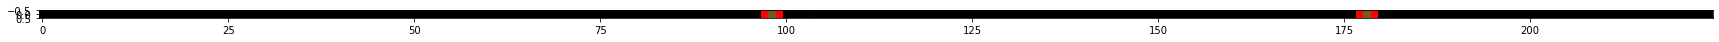

In [646]:

strip, _ = frame_to_pixel_strip(get_frame(high_score, 6326), vert_offset=0 )
count, bean_loc = count_close_colors(strip, mode='deltae')
print(bean_loc)
show_pixel_strip(strip, bean_loc)



In [677]:
def count_beans_by_frame(filename, debug=False):
    frame_num=0
    last_spawned_frame = 0
    counts = []
    speeds = []
    fall_history = []
    video=cv2.VideoCapture(filename)
    while video.isOpened():
        rete,frame=video.read()
        if rete:
            # count the beans here
            frame = np.flip(frame, -1)
            strip, bean_table = frame_to_pixel_strip(frame)
            if len(fall_history) == 0:
                fall_history = bean_table
            count, bean_loc = count_close_colors(strip, mode='deltae')
            # If no beans were found, check lower strip
            if count == 0:
                lower_strip, bean_table = frame_to_pixel_strip(frame, vert_offset=1)
                count, bean_loc  = count_close_colors(lower_strip, mode='deltae')
            if count > 0:
                frame_diff = frame_num - last_spawned_frame
                counts.append((frame_num, frame_diff, count))
                last_spawned_frame = frame_num
                if frame_diff > 4:
                    fall_history[bean_loc] = frame_num
                    if debug:
                        print(frame_num, frame_diff, count)
                        show_pixel_strip(strip, bean_loc)
            
            # check bottom of screen to measure fall speed
            finish_strip, _ = frame_to_pixel_strip(frame, vert_offset=FALL_DIST) 
            finish_count, finish_loc = count_close_colors(finish_strip, mode='deltae')
            if finish_count == 0:
                finish_strip, _ = frame_to_pixel_strip(frame, vert_offset=FALL_DIST+1) 
                finish_count, finish_loc = count_close_colors(finish_strip, mode='deltae')
            # if there was a bean in this column earlier
            for loc in finish_loc:
                if fall_history[loc] > 0:
                    fall_time = frame_num - fall_history[loc]
                    speeds.append((frame_num, fall_time, finish_count))
                    fall_history[loc] = 0
            
            frame_num +=1
        else:
            break
    video.release()
    
    return counts, speeds

def make_dataframe(counts, fps, mode='rate'):
    frame, frame_diffs, spawn_count = list(zip(*counts))
    data = pd.DataFrame({'frame':frame, 'interval':frame_diffs, 'count':spawn_count})
    data = data[(data.interval >= 5)]
    
    data['interval_sec'] = data.interval / fps
    data['game_sec'] = data.frame / fps
    data['label'] = ''
    #data.loc[data.spawn_interval_sec >= 1.5, 'label'] = data.frame
    if mode == 'speed':
        data.interval =  data.interval / FALL_DIST # convert to frames/pixel
        data['pixels_per_frame'] = 1 / data.interval
        data['pixels_per_sec'] = data.pixels_per_frame * fps
        data = data[(data.pixels_per_sec <= 200) & (data.pixels_per_sec >= 20)]
        data['y'] = data.pixels_per_sec
    else:
        data['y'] = data.interval_sec
    
    data['x'] = data.game_sec
    return data

def encode_stage_by_frame(data, frame_coding):
    data['stage'] = 0
    for stage, frame_num in enumerate(frame_coding):
        data.loc[data.frame >= frame_num, 'stage'] = stage


In [654]:
def logf(x, a, b, c, d):
    #return a / (1. + np.exp(-c * (x - d))) + b
    return a * np.exp(c * (-x + d)) + b

def print_logf(a, b, c, d):
    s = f'f(x) = {a}e^(-{c}x+{d*c}) + {b}'
    print(s)
    return s 

def log_fit_curve(data, xs = []):
    if len(xs) == 0:
        xs = np.arange(0, data.x.max())
    popt, pcov = opt.curve_fit(logf, data.x, data.y, method='trf')
    ypred = logf(xs, *popt)
    function_str = print_logf(*np.round(popt,2))

    return pd.DataFrame({'x':xs, 'y':ypred}), function_str

def plot_curve(data, model=None, title='', f_str=''):
    plot = (ggplot(data) 
        + aes(x='x', y='y', color='factor(stage)')
        + labs(x='Game Time (sec)', y='Spawn Interval (sec)', title=title, color="Score (thousands)")
        + geom_point()
        + geom_text(aes(label='label'), color='black')
    )

    if model is not None:
        plot += geom_line(aes(x='x', y='y'), data=model, color='black', size=1.5)
        plot += annotate('text', x=model.x.max()-55, y=model.y.max(), label=f_str)
    return plot

In [653]:
low_score_counts = count_beans_by_frame(low_score)
high_score_counts = count_beans_by_frame(high_score)

In [679]:
def do_analysis(filename, counts, speeds):
    fps = 30
    stage_coding = [0]
    if filename == high_score:
        fps = 60
        stage_coding = [0, 270, 491, 631, 824, 954, 1057, 1252, 1424, 1578, 1655, 1825, 1847]
    
    rate_data = make_dataframe(counts, fps)
    speed_data = make_dataframe(speeds, fps, mode='speed')

    encode_stage_by_frame(rate_data, stage_coding)
    encode_stage_by_frame(speed_data, stage_coding)

    rate_model, f_str1 = log_fit_curve(rate_data)
    rate_plot = plot_curve(rate_data, rate_model, title=f'Bean Spawn Rate {filename}', f_str=f_str1)
    
    speed_plot = plot_curve(speed_data, title=f'Bean Fall Speed {filename}')
    speed_plot += labs(y='Fall Speed (pixels/sec)')

    display(rate_plot)
    display(speed_plot)
    return (rate_data, speed_data), (rate_plot, speed_plot)

f(x) = 1.91e^(-0.02x+0.0366) + 0.65


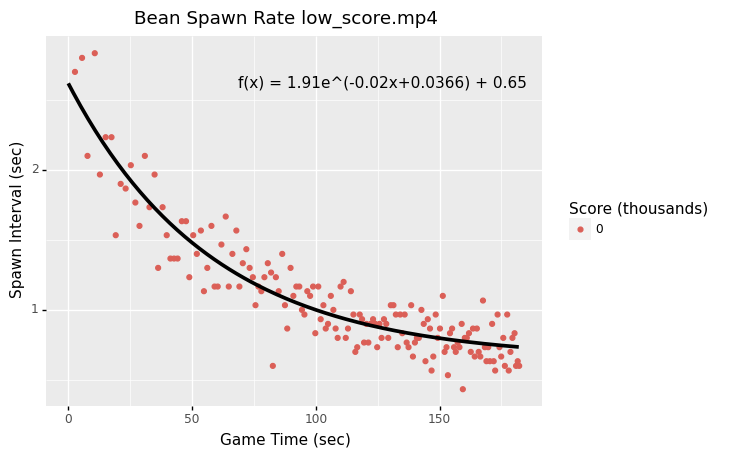

<ggplot: (8760015948837)>

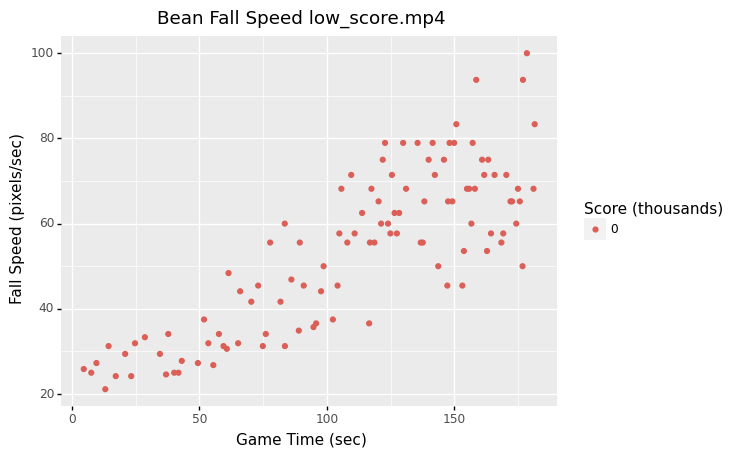

<ggplot: (8760008844285)>

In [680]:
data, plots = do_analysis(low_score, *low_score_counts)

f(x) = 2.13e^(-0.09x+0.5634) + 0.26


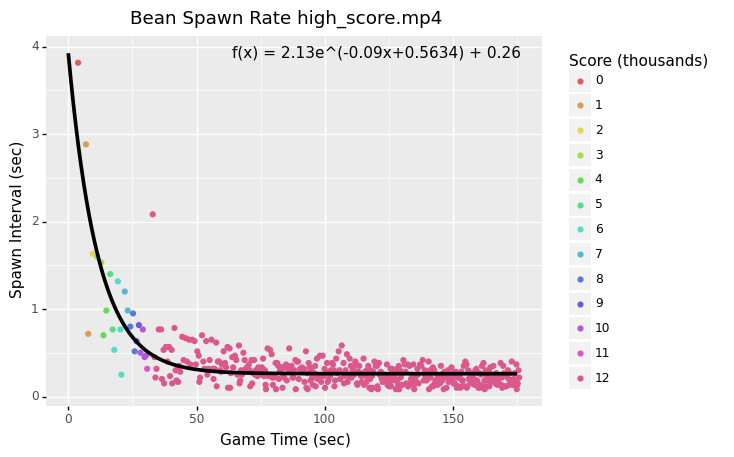

<ggplot: (8760016831022)>

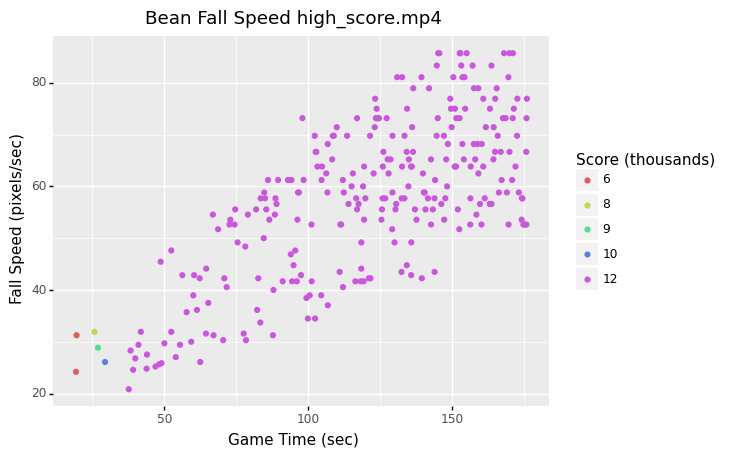

<ggplot: (8760010086684)>

In [681]:
data, plots = do_analysis(high_score, *high_score_counts)

In [ ]:
for i in range(0, 0):
        group_loc = np.argmax(groups > i)
        if group_loc == 0:
            continue
        # only count this bean if it is the first one seen in this group position 
        if beans[group_loc] == 0:
            bean_count += 1 # first spotting of new bean!
        if beans[group_loc] < 3: # This is within the first 3 frames of this beans existenance 
            beans[group_loc] += 1
        else: # we have already counted this bean for 3 frames, so clear it
            beans[group_loc] = 0